# Text Analysis

This is gonna be runnable but quite slow on a CPU. Best to find yourself a GPU!

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchtext
gen_mask = torch.nn.Transformer.generate_square_subsequent_mask

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# warnings are again annoying
import warnings
warnings.filterwarnings('ignore')

In [5]:
# use gpu if available
device = 'cuda' if torch.has_cuda else 'cpu'
print(device)

cuda


### Utils

In [6]:
def vectorize_string(prompt, L, pad=None):
    tokens = prompt.split()
    ntoks = len(tokens)
    if ntoks < L:
        tokens = ['<unk>']*(L-ntoks) + tokens
    elif ntoks > L:
        tokens = tokens[-L:]
    indices = torch.tensor(vocab.lookup_indices(tokens))
    return indices

In [7]:
def sample_dist(lprobs, temp=None):
    tprobs = lprobs.exp().pow(1/temp)
    return torch.multinomial(tprobs, 1)

In [8]:
def print_tokens(tokens):
    s = ' '.join(tokens)
    s = re.sub(r' \n ', r'\n\n', s)
    s = re.sub(r' (,|\.|!|\?) ', r'\1 ', s)
    s = re.sub(r'<unk>', r'', s)
    s = re.sub(r' {2,}', r' ', s)
    s = re.sub(r'(^ +| +$)', r'', s, flags=re.MULTILINE)
    return s

### Load Data

In [9]:
def process_text(s):
    # merge punctuation
    s = re.sub(r'(;|\-\-)', r',', s)
    s = re.sub(r'\-', ' ', s)
    s = re.sub(r'(,|\.|!|\?|")', r' \1 ', s)

    # merge whitespace
    s = re.sub(r'(?<!\n)\n(?!\n)', ' ', s)
    s = re.sub(r'\n{2,}', '\n', s)
    s = re.sub(r' {2,}', ' ', s)

    # strip lines
    s = re.sub(r'(^ +| +$)', r'', s, flags=re.MULTILINE)
    s = re.sub(r'\n', r' \n ', s)

    return s.lower()

In [10]:
# load in text data
with open('data/melville-moby_dick.txt') as fid:
    moby = fid.read()

In [11]:
# process text
text = process_text(moby[21444:])
print(text[:300])
print('\n...\n')
print(text[-300:])

chapter 1 
 loomings . 
 call me ishmael . some years ago , never mind how long precisely , having little or no money in my purse , and nothing particular to interest me on shore , i thought i would sail about a little and see the watery part of the world . it is a way i have of driving off the sple

...

y glided by as if with padlocks on their mouths , the savage sea hawks sailed with sheathed beaks . on the second day , a sail drew near , nearer , and picked me up at last . it was the devious cruising rachel , that in her retracing search after her missing children , only found another orphan . 
 


In [12]:
# make vocab and digitize
tokens = text.split(' ')
vocab = torchtext.vocab.build_vocab_from_iterator([tokens], min_freq=2, specials=["<unk>"])
vocab.set_default_index(0)
indices = torch.tensor(vocab.lookup_indices(tokens))
print(len(indices))

252984


## Markov Style

In [68]:
# parameters
Lm = 10 # context size
Km = 25 # number of epochs

In [69]:
# convert to overlapping sequences
sequence_markov = torch.stack([indices[i:-Lm+i] for i in range(Lm)]).T
outcome_markov = indices[Lm:]
dataset_markov = torch.utils.data.TensorDataset(sequence_markov.to(device), outcome_markov.to(device))
dataload_markov = torch.utils.data.DataLoader(dataset_markov, batch_size=512)

In [70]:
# make prediction model
class Markov(torch.nn.Module):
    def __init__(self, vocab_size, context_size, embedding_dim=32, hidden_size=128):
        super().__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = torch.nn.Linear(context_size*embedding_dim, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        size = self.context_size*self.embedding_dim
        embeds = self.embeddings(inputs).view((-1, size))
        out = torch.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs

0
5
10
15
20
24


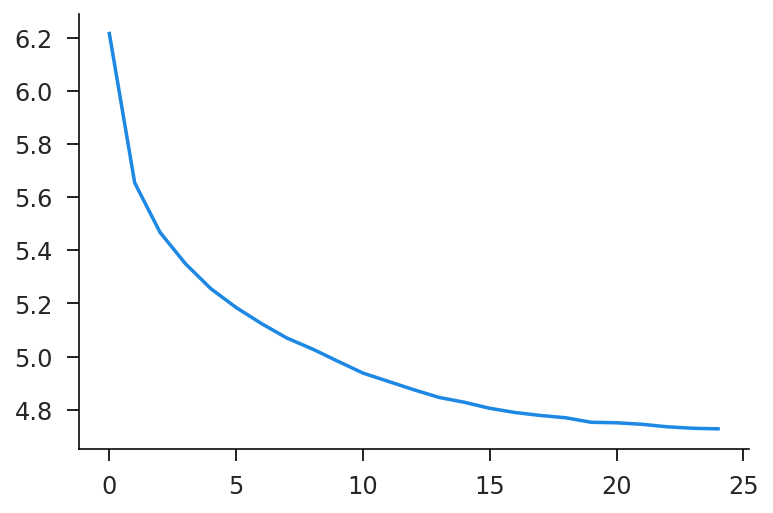

In [74]:
# make model and optimizer
model_markov = Markov(len(vocab), Lm, embedding_dim=32, hidden_size=128).to(device)
cross = torch.nn.NLLLoss()
optim = torch.optim.Adam(model_markov.parameters(), lr=0.01)

# track history
history = []

# go for many iterations
for i in range(Km):
    if i % 5 == 0 or i == Km - 1:
        print(i)

    # accumulate stats per batch
    nbatch = 0
    loss_avg = 0.0

    # iterate over batches
    for j, (x, y) in enumerate(dataload_markov):
        # compute loss
        logits = model_markov(x)
        loss = cross(logits, y)

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()

        # add batch stats
        nbatch += 1
        loss_avg += loss.detach()

    # make it a mean
    loss_avg /= nbatch
    history.append(loss_avg.item())

# turn history into dataframe
history = pd.Series(history, name='loss')
history.plot();

In [75]:
def predict_markov(prompt, num=1, temp=1.0):
    tokens = vectorize_string(prompt, Lm).to(device)
    output = torch.tensor([], dtype=torch.int, device=device)
    for i in range(num):
        log_probs = model_markov(tokens).squeeze()
        sel_index = sample_dist(log_probs, temp=temp)
        tokens = torch.cat([tokens[1:], sel_index])
        output = torch.cat([output, sel_index])
    words = vocab.lookup_tokens(output.tolist())
    return print_tokens(words)

In [76]:
prompt = 'ahab walked to the edge of the boat and looked out upon the sea'
print(prompt)
print()
print(predict_markov(prompt, num=100, temp=2.0))

ahab walked to the edge of the boat and looked out upon the sea

which charge had all others been best there rising by strict to regard some so shiver that to indifference and prudential were he cables rising to unconquerable to feeling for pip confounded the love man heavens went over, doubtless. placed down extreme rising but he dexterously wouldst jaw about the more fowl. canst how when different hair operated into the earthly wonderful were so broadly. away and. cup there pulled them, stand who! me take cold and passenger somewhere like it warming work, , hanging cover these coast he cared at will


## Word RNN (LSTM)

In [77]:
# parameters
Lr = 10 # context size
Kr = 250 # number of epochs
Vr = len(vocab) # size of vocab
Fr = (len(indices) - 1) // Lr # number of frames
Nr = Lr*Fr # trimmed datasize
Br = 1024 # batch size

In [78]:
# convert to non-overlapping sequences
sequence_rnn = indices[:Nr].view(-1, Lr)
outcomes_rnn = indices[1:Nr+1].view(-1, Lr)
dataset_rnn = torch.utils.data.TensorDataset(sequence_rnn.to(device), outcomes_rnn.to(device))
dataload_rnn = torch.utils.data.DataLoader(dataset_rnn, batch_size=Br, drop_last=True)

In [79]:
# make prediction model — takes [L,N]
class WordRNN(torch.nn.Module):
    def __init__(self, vocab_size, sequence_len, embedding_dim=32, hidden_size=128):
        super().__init__()
        self.seqlen = sequence_len
        self.embdim = embedding_dim
        self.embed = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_size, num_layers=2, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, state_in=None):
        emb = self.embed(inputs)
        out, state_out = self.lstm(emb, state_in)
        out = self.linear(out)
        log_probs = torch.log_softmax(out, dim=-1)
        return log_probs, state_out

0
25
50
75
100
125
150
175
200
225
249


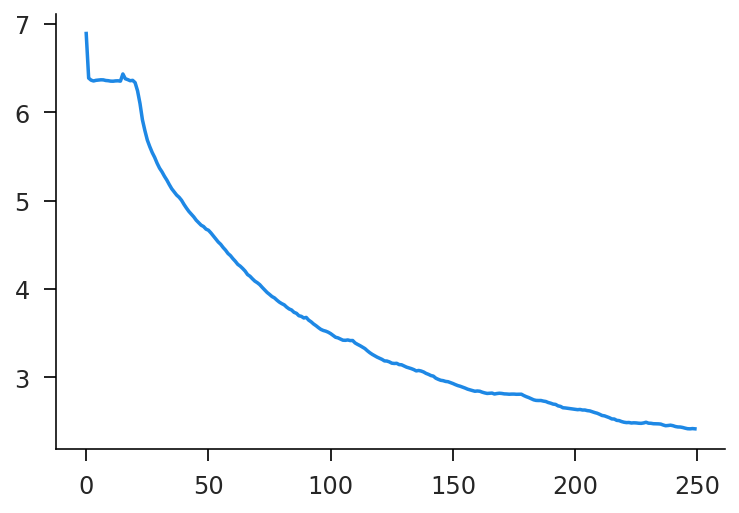

In [80]:
# make model and optimizer
model_rnn = WordRNN(len(vocab), Lr, embedding_dim=32, hidden_size=128).to(device)
cross = torch.nn.NLLLoss()
optim = torch.optim.Adam(model_rnn.parameters(), lr=0.01)

# track history
history = []

# go for many iterations
for i in range(Kr):
    if i % 25 == 0 or i == Kr - 1:
        print(i)

    # accumulate stats per batch
    nbatch = 0
    loss_avg = 0.0

    # iterate over batches
    state_rnn = None
    for j, (x, y) in enumerate(dataload_rnn):
        # compute loss
        logits, state_new = model_rnn(x, state_rnn)
        loss = cross(logits.view(-1, Vr), y.view(-1))

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # update state
        state_rnn = tuple(s.detach() for s in state_new)

        # add batch stats
        nbatch += 1
        loss_avg += loss.detach()

    # make it a mean
    loss_avg /= nbatch
    history.append(loss_avg.item())

# turn history into dataframe
history = pd.Series(history, name='loss')
history.plot();

In [81]:
def predict_rnn(prompt, num=1, temp=1.0, state=None):
    tokens = vectorize_string(prompt, Lr).to(device)
    output = torch.tensor([], dtype=torch.int, device=device)
    for i in range(num):
        predict, state = model_rnn(tokens, state)
        select = sample_dist(predict[0, :], temp=temp)
        tokens = torch.cat([tokens[1:], select])
        output = torch.cat([output, select])
    words = vocab.lookup_tokens(output.tolist())
    return print_tokens(words)

In [82]:
prompt = 'ahab walked to the edge of the boat and looked out upon the sea'
print(prompt)
print()
print(predict_rnn(prompt, num=100, temp=1.5))

ahab walked to the edge of the boat and looked out upon the sea

to all sun. no straight at him sperm, you hammer hides now reasons, a! whale's it's must a among fish, timidity here father such poor it, it your, , roared whalemen, black will ambiguous not little by dismal bildad, shouted and it was meant suspended another, . still perhaps found at that here last fowls after, their in, chase the ain't creature! the steelkilt long play that to real all in fedallah hoops the, on this his opinion me thirty or. whale here


## Transformer (Encoder)

In [55]:
# parameters
Lt = 50 # context size
Kt = 250 # number of epochs
Vt = len(vocab) # size of vocab
Ft = (len(indices) - 1) // Lt # number of frames
Nt = Lt*Ft # trimmed datasize
Bt = 256 # batch size

In [56]:
# convert to non-overlapping sequences
sequence_trans = indices[:Nt].view(-1, Lt)
outcomes_trans = indices[1:Nt+1].view(-1, Lt)
dataset_trans = torch.utils.data.TensorDataset(sequence_trans.to(device), outcomes_trans.to(device))
dataload_trans = torch.utils.data.DataLoader(dataset_trans, batch_size=Bt, drop_last=True)

In [32]:
# make prediction model — takes [L,N]
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size, sequence_len, embedding_dim=32, nhead=8, num_layers=3, dropout=0.5):
        super().__init__()
        self.register_buffer('mask', gen_mask(sequence_len))

        self.embed = torch.nn.Embedding(vocab_size, embedding_dim)
        trans_layer = torch.nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = torch.nn.TransformerEncoder(trans_layer, num_layers=num_layers)
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)

        initrange = 0.1
        torch.nn.init.uniform_(self.embed.weight, -initrange, initrange)
        torch.nn.init.zeros_(self.linear.bias)
        torch.nn.init.uniform_(self.linear.weight, -initrange, initrange)

    def forward(self, inputs, mask=True):
        mask1 = self.mask if mask else None
        emb = self.embed(inputs)
        out = self.transformer(emb, mask1)
        out = self.linear(out)
        log_probs = torch.log_softmax(out, dim=-1)
        return log_probs

In [33]:
# make model and optimizer
model_trans = Transformer(len(vocab), Lt, embedding_dim=128, nhead=8, num_layers=3, dropout=0.5)
model_trans = model_trans.to(device).train()
cross = torch.nn.NLLLoss()
optim = torch.optim.Adam(model_trans.parameters(), lr=0.001)

# track history
history = []

# go for many iterations
for i in range(Kt):
    # accumulate stats per batch
    nbatch = 0
    loss_avg = 0.0

    # iterate over batches
    for j, (x, y) in enumerate(dataload_trans):
        # compute loss
        logits = model_trans(x, mask=True)
        loss = cross(logits.view(-1, Vt), y.view(-1))

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()

        # add batch stats
        nbatch += 1
        loss_avg += loss.detach()

    # make it a mean
    loss_avg /= nbatch
    history.append(loss_avg.item())

    # output info
    if i % 25 == 0 or i == Kt- 1:
        print(i, loss_avg.item())

# set model to eval mode
model_trans.eval()
        
# turn history into dataframe
history = pd.Series(history, name='loss')
history.plot();

NameError: name 'Lt' is not defined

In [101]:
def predict_trans(prompt, num=1, temp=1.0, state=None):
    tokens = vectorize_string(prompt, Lt).to(device)
    output = torch.tensor([], dtype=torch.int, device=device)
    for i in range(num):
        predict = model_trans(tokens, mask=False)
        select = sample_dist(predict[-1, :], temp=temp)
        tokens = torch.cat([tokens[1:], select])
        output = torch.cat([output, select])
    words = vocab.lookup_tokens(output.tolist())
    return print_tokens(words)

In [102]:
prompt = 'ahab walked to the edge of the boat and looked out upon the sea'
print(prompt)
print()
print(predict_trans(prompt, num=200, temp=1.5))

ahab walked to the edge of the boat and looked out upon the sea

calm weather and finally flew thrice their breath only strange coat, resuming his walk near the future he summoned the spring, sharp, so it were, there ready at the same spot where you would once saw but now glided close to those whales, but so close enough in plain in much we haul in some lurid like a substitute for them would have but was first murder spasmodically sank imparts .

but like oysters for it? for theirs. strange (and i hope of the water? would digest even here three hundred would at first convenient to . what go .

apply. from these floated on the water like an young savage bearing accompanied us the assault .

his undeniable delirium at events, and then tempered .

below, was, therefore came over base delight end, because flag days come from new would have likewise rest, as mout is not well believe .

peculiarities here they think of human wild indian ocean how i will sometimes go so clothed in our vicinit

## Transformer (Autoencoder)

In [13]:
# parameters
La = 50 # context size
Ka = 250 # number of epochs
Va = len(vocab) # size of vocab
Fa = (len(indices) - 1) // La # number of frames
Na = La*Fa # trimmed datasize
Ba = 256 # batch size

In [14]:
# convert to non-overlapping sequences
sequence_auto = indices[:Na].view(-1, La)
outcomes_auto = indices[1:Na+1].view(-1, La)
dataset_auto = torch.utils.data.TensorDataset(sequence_auto.to(device), outcomes_auto.to(device))
dataload_auto = torch.utils.data.DataLoader(dataset_auto, batch_size=Ba, drop_last=True)

In [15]:
# make prediction model — takes [L,N]
class Transformer_Auto(torch.nn.Module):
    def __init__(self, vocab_size, sequence_len, embedding_dim=32, nhead=8, num_layers=3, dropout=0.5):
        super().__init__()
        self.register_buffer('mask', torch.nn.Transformer.generate_square_subsequent_mask(sequence_len))
        self.embed = torch.nn.Embedding(vocab_size, embedding_dim)
        self.transformer = torch.nn.Transformer(
            d_model=embedding_dim, nhead=nhead, num_encoder_layers=num_layers,
            num_decoder_layers=num_layers, dropout=dropout, batch_first=True
        )
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs, outputs, mask=True):
        mask1 = self.mask if mask else None
        embi = self.embed(inputs)
        embo = self.embed(outputs)
        tout = self.transformer(embi, embo, src_mask=mask1, tgt_mask=mask1)
        out = self.linear(tout)
        return out

0 -1.9922667741775513
25 -146.77883911132812
50 -486.2554016113281
75 -1022.350341796875
100 -1756.9942626953125
125 -2661.51904296875
150 -3713.5625
175 -4899.29736328125
200 -6210.3828125
225 -7641.4375
249 -9124.591796875


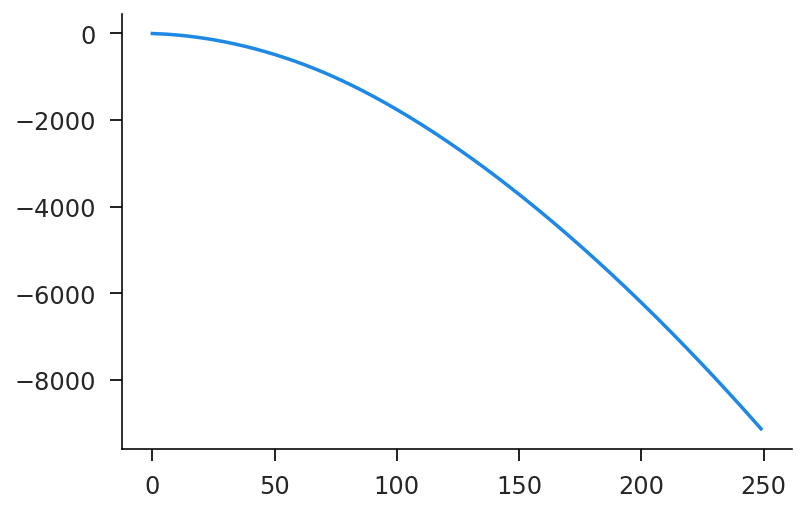

In [17]:
# make model and optimizer
model_auto = Transformer_Auto(Va, La, embedding_dim=128, nhead=8, num_layers=3, dropout=0.5)
model_auto = model_auto.to(device).train()
cross = torch.nn.NLLLoss()
optim = torch.optim.Adam(model_auto.parameters(), lr=0.001)

# track history
history = []

# go for many iterations
for i in range(Ka):
    # accumulate stats per batch
    nbatch = 0
    loss_avg = 0.0

    # iterate over batches
    for j, (x, y) in enumerate(dataload_auto):
        # compute loss
        logits = model_auto(x, y, mask=True)
        loss = cross(logits.view(-1, Va), y.view(-1))

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()

        # add batch stats
        nbatch += 1
        loss_avg += loss.detach()

    # make it a mean
    loss_avg /= nbatch
    history.append(loss_avg.item())

    # output info
    if i % 25 == 0 or i == Ka- 1:
        print(i, loss_avg.item())

# set model to eval mode
model_auto.eval()
        
# turn history into dataframe
history = pd.Series(history, name='loss')
history.plot();